In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random
import time
import os

# Adjust the options for viewing charts in notebook
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':100})

# Adjust options for viewing dataframes in notebook
pd.set_option('display.width', 2000)

# Set random seed to get the same result after each time running the code
tf.random.set_seed(1234)

In [2]:
# Function for reading a data file
def read_data(name):
    df = pd.read_csv('./../../data/clean_data/' + name + '.csv')
    df['Hour'] = pd.to_datetime(df['Hour'])
    df = df.set_index('Hour')
    df.index.freq = 'h'
    return df

In [3]:
# Function for creating datasets for machine learning
def create_dataset (input_data, look_back):
    features, values = [], []
    
    for i in range(len(input_data)-look_back):
        feature = input_data[i:i+look_back]
        features.append(feature)
        values.append(input_data[i+look_back])
        
    return np.array(features), np.array(values)

In [4]:
# Function for creating a GRU model
def create_gru(units, trainX):
    model = Sequential()
    model.add(tf.keras.Input(shape=(trainX.shape[1], trainX.shape[2])))     # Define shape
    model.add(GRU (units = units, return_sequences = True))                # Input layer 
    model.add(GRU(units = units))                                          # Hidden layer
    model.add(Dense(units = 1))                                             # Output layer
    model.compile(optimizer='adam', loss='mse')                             # Compile model
    return model

In [5]:
# Function for making predictions iteratively using self-feedback
def iterative_forecast(model, trainY, forecast_duration, look_back):
    forecast = []                           # Results
    look_back_data = trainY[-look_back:]    # Initial input
    train_mean = trainY[:,1].mean()         # Mean demand value
    train_max = trainY[:,1].max()           # Max. demand value

    # Predict iteratively
    i = 0
    while i < forecast_duration:
        prediction = model.predict(np.expand_dims(look_back_data, axis=0), verbose=0)

        # Round predictions below mean to zero
        if prediction[0][0] < train_mean:
            prediction[0][0] = 0
        # Cap predictions at max. demand value
        elif prediction[0][0] > train_max:
            prediction[0][0] = train_max
        
        look_back_minus_last = np.delete(look_back_data, 0, axis=0)             # Remove oldest input sample
        next_hour = np.array((look_back_minus_last[-1,0] + 1) % 24)             # Calculate next hour feature
        new_point = pd.DataFrame({'hour': next_hour, 'energy': prediction[0]})  # Combine next hour and predicted demand
        look_back_data = np.append(look_back_minus_last, new_point, axis=0)     # Add predicted values as input for next prediction
        forecast.append(prediction[0][0])                                       # Record result
        i = i + 1

    return forecast

In [6]:
# Function for locating random batches from dataset

## Take dataset, length of training data, length of testing data and number of batches to extract as parameters
## Find a number of digits that represent the indices of the original dataset, where the extracted batches will start from
## Each subset dataset will not intersect with other datasets
def extract_batches(df, train_length, test_length, batch_count):
    start = time.time()
    random_int_list = []
    m = 0
    random.seed(1)
    data_end = len(df)
    new_data_size = train_length + test_length
    while m < batch_count:
        random_int = random.randint(0, data_end - new_data_size)
        q = 0
        for i in random_int_list:
            # Make sure batches do not overlap
            if i + new_data_size <= random_int or random_int + new_data_size <= i:
                pass
            else:
                q = 1
                # In case solution does not exist with current combination
                if time.time() - start > 2:
                    print('Restarted')
                    random_int_list = []
                    start = time.time()
                    m = 0

        # Prevent batches with 0 energy
        if df['Energy'][random_int: random_int + train_length].sum() == 0:
            q = 1
        elif df['Energy'][random_int + train_length: random_int + new_data_size].sum() == 0:
            q = 1

        # Record the position of the batch
        if q == 0:
            random_int_list.append(random_int)
            m = m + 1
    return random_int_list

In [9]:
# Function for plotting training, predicted, and actual values
def plot(train, predictions, actual):
    plt.plot(actual.index, actual.values, label='Actual', color='red')
    plt.plot(train.index, train.values, label='Train', color='orange')
    plt.plot(actual.index, predictions.values, label='Forecast', color='blue')
    
    plt.title('Forecast vs Actuals')
    plt.ylabel('Energy Consumption')
    plt.legend(loc='upper left', fontsize=8)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))

    plt.show()

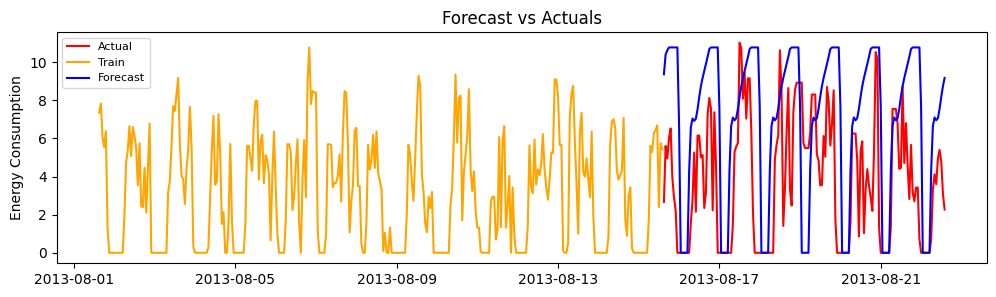

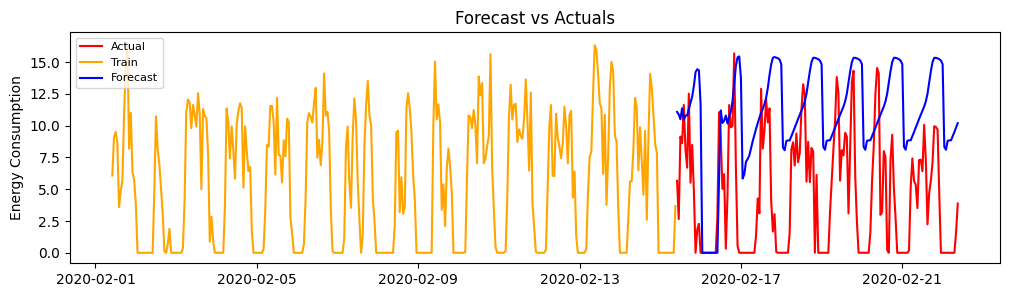

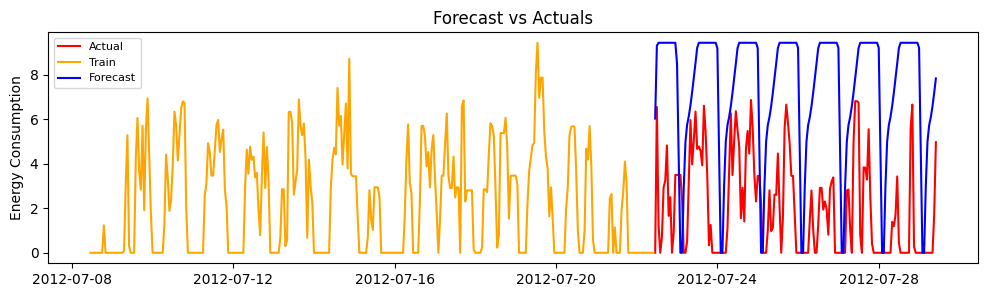

,Batch 1,Batch 2,Batch 3,Average
Time (s),16.86,15.904,15.15,15.971


In [8]:
# Read data
df = read_data('HAMILTON')

train_length = 336      # 14 days
test_length = 168       # 7 days
look_back = 24          # How many past values are considered as features
nodes_per_layer = 128   # How many nodes in each of the model's layers

# If the training data is too short, modify look_back
if look_back >= train_length:
    look_back = train_length // 2

# Find appropriate, random, non-overlapping batch locations
start_index_list = extract_batches(df, train_length, test_length, 3)

# Create the empty results dataframe to hold the results
df_results = pd.DataFrame()
row_headers = ['Time (s)']

# For each batch
for start_index in start_index_list:
    # Record the training and testing dataset of the batch
    train = df[start_index: start_index + train_length]
    test = df[start_index + train_length: start_index + train_length + test_length]

    # Start the timer
    start = time.time()

    # Prepare data set for training and testing the model
    features = pd.DataFrame({'hour': train.index.hour, 'energy': train.Energy.values})
    trainX, trainY = create_dataset(np.array(features), look_back)
    testY = test.Energy

    # Create and train the GRU model
    model_gru = create_gru(nodes_per_layer, trainX)
    model_gru.fit(trainX, trainY, epochs=50, batch_size=16, verbose=0)

    # Make predictions
    predictions = iterative_forecast(model_gru, trainY, test_length, look_back)

    # End the timer
    time_value = np.round(time.time() - start, 3)

    # Append the batch results to the results dataframe
    row = [time_value]
    df_results = pd.concat([df_results, pd.DataFrame([row], columns=row_headers)], ignore_index=True)

    # Plot
    predicted_values = pd.Series(predictions, index=testY.index)
    plot(train=train, predictions=predicted_values, actual=testY)

# Calculate the average of each column
average_value_list = np.round(df_results.mean(), 3).tolist()

# Append the average to each column
df_results = pd.concat([df_results, pd.DataFrame([average_value_list], columns=row_headers)], ignore_index=True)

# Reformat the results dataframe
df_results = df_results.transpose()
df_results.columns = ['Batch 1', 'Batch 2', 'Batch 3', 'Average']

# Display results
display(df_results)

In [10]:
# Function for running the execution time tests and collecting the results
def analyse(df, train_length, test_length, batch_count):
    look_back = 24               # How many past values are considered as features
    nodes_per_layer = 128        # How many nodes in each of the model's layers

    # If the training data is too short, modify look_back
    if look_back >= train_length:
        look_back = train_length // 2

    # Find appropriate (random) indices for batches to prevent overlap
    start_index_list = extract_batches(df, train_length, test_length, batch_count)

    # Create the empty results dataframe to hold the results
    row_headers = ['Energy (kWh)', 'Time (s)']
    df_results = pd.DataFrame()

    # For each batch
    for start_index in start_index_list:
        # Record the training and testing dataset of the batch
        train = df[start_index: start_index + train_length]
        test = df[start_index + train_length: start_index + train_length + test_length]

        # Start the timer
        start = time.time()

        # Prepare data set for training and testing the model
        features = pd.DataFrame({'hour': train.index.hour, 'energy': train.Energy.values})
        trainX, trainY = create_dataset(np.array(features), look_back)
        testY = test.Energy

        # Create and train the GRU model
        model_gru = create_gru(nodes_per_layer, trainX)
        model_gru.fit(trainX, trainY, epochs=50, batch_size=16, verbose=0)

        # Make predictions
        predictions = iterative_forecast(model_gru, trainY, test_length, look_back)

        # End the timer
        time_value = np.round(time.time() - start, 3)

        # Calculate total energy demand in batch
        demand_value = np.round(test['Energy'].sum(), 3)

        # Append the batch results to the results dataframe
        row = [demand_value, time_value]
        df_results = pd.concat([df_results, pd.DataFrame([row], columns=row_headers)], ignore_index=True)

    # Calculate the average of each column
    average_value_list = np.round(df_results.mean(), 3).tolist()
    # Calculate the minimum of each column
    min_value_list = np.round(df_results.min(), 3).tolist()
    # Calculate the maximum of each column
    max_value_list = np.round(df_results.max(), 3).tolist()
    # Calculate the standard deviation of each column
    stddev_value_list = np.round(df_results.std(), 3).tolist()
 
    # Append the average to each column
    df_results = pd.concat([df_results, pd.DataFrame([average_value_list], columns=row_headers)], ignore_index=True)
    # Append the minimum to each column
    df_results = pd.concat([df_results, pd.DataFrame([min_value_list], columns=row_headers)], ignore_index=True)
    # Append the maximum to each column
    df_results = pd.concat([df_results, pd.DataFrame([max_value_list], columns=row_headers)], ignore_index=True)
    # Append the standard deviation to each column
    df_results = pd.concat([df_results, pd.DataFrame([stddev_value_list], columns=row_headers)], ignore_index=True)

    # Reformat the results dataframe
    df_results = df_results.transpose()
    df_results.columns = ['Batch 1', 'Batch 2', 'Batch 3', 'Batch 4', 'Batch 5', 'Batch 6', 'Batch 7', 'Batch 8', 'Batch 9', 'Batch 10',
                            'Average', 'Minimum', 'Maximum', 'Std. Dev.']
    
    # Display results
    display(df_results)

    return df_results

In [11]:
# Conducting extensive batch testing of execution time on different forecast periods and training period lengths, with 10 random batches each
def main(name):
    # Make the directory for the results
    if os.path.isdir('../../data/execution_time_results/GRU'):
        pass
    else:
        os.makedirs('../../data/execution_time_results/GRU')

    print('-- Performance metric testing --')
    df = read_data(name)
    print('\n{}'.format(name))
    file_name = '../../data/execution_time_results/GRU/' + name + '_GRU.xlsx'

    # Write the tables to appropriate xlsx files
    with pd.ExcelWriter(file_name, mode='w', engine='xlsxwriter') as writer:

        # Run the tests for each training type
        q = 0
        while q < 3:
            # Modify execution parameters if needed
            test_length = [336, 168, 72, 24]                               # Hours in testing set
            batch_count = [10, 10, 10, 10]                                 # Batch count
            start_row = [1, 5, 9, 13]                                      # Row position in xlsx file to write results in
            durations = ['14 Days', '7 Days', '3 Days', '1 Day']           # Durations of batches, used for titles

            if q == 0:
                # 1. Two weeks training data
                print('-- Two Weeks Training Data --')
                pd.DataFrame(['14 Days Training']).to_excel(writer, sheet_name=name, startrow=0, header=None, index=None)

                train_length = [336, 336, 336, 336]                        # Hours in training set
                start_col = 0                                              # Column position in xlsx file to write results in
            elif q == 1:
                # 2. 75:25 Ratio of training to testing data
                print('-- 75:25 Ratio of Training to Testing Data --')
                pd.DataFrame(['Training:Testing = 75:25']).to_excel(writer, sheet_name=name, startrow=0, startcol=16, header=None, index=None)

                train_length = [1008, 504, 216, 72]                        # Hours in training set
                start_col = 16                                             # Column position in xlsx file to write results in
            else:
                # 3. 50:50 Ratio of training to testing data
                print('-- 50:50 Ratio of Training to Testing Data --')
                pd.DataFrame(['Training:Testing = 50:50']).to_excel(writer, sheet_name=name, startrow=0, startcol=32, header=None, index=None)

                train_length = [336, 168, 72, 24]                          # Hours in training set
                start_col = 32                                             # Column position in xlsx file to write results in

            all_results_list = []

            i = 0
            while i < len(test_length):
                print('{} Ahead Forecast:'.format(durations[i]))

                # Run set of batches and collect results
                df_results = analyse(df, train_length[i], test_length[i], batch_count[i])
                all_results_list.append(df_results)

                # Write results to xlsx file
                df_results.to_excel(writer, sheet_name=name, startrow=start_row[i], startcol=start_col)
                pd.DataFrame(['{} Forecast'.format(durations[i])]).to_excel(writer, sheet_name=name, startrow=start_row[i], startcol=start_col, header=None, index=None)
                i = i + 1

            # Create summary dataframes
            df_summary_avg = pd.concat([df['Average'] for df in all_results_list], axis="columns")
            df_summary_min = pd.concat([df['Minimum'] for df in all_results_list], axis="columns")
            df_summary_max = pd.concat([df['Maximum'] for df in all_results_list], axis="columns")
            df_summary_stddev = pd.concat([df['Std. Dev.'] for df in all_results_list], axis="columns")

            for i in [df_summary_avg, df_summary_min, df_summary_max, df_summary_stddev]:
                i.columns = durations

            # Modify summary parameters if needed
            start_row = [17, 21, 25, 29]                                                        # Row position in xlsx file to write results in
            summary_name = [df_summary_avg, df_summary_min, df_summary_max, df_summary_stddev]  # Summary reference list
            print_title = ['Average', 'Minimum', 'Maximum', 'Standard Deviation']               # Title for printing results
            summary_title = ['Avg.', 'Min.', 'Max.', 'Std.Dev.']                                # Dataframe title in xlsx file

            i = 0
            while i < 4:
                print('{} Values Summary - {}:'.format(print_title[i], name))

                # Display summary
                display(summary_name[i])

                # Write summary to xlsx file
                summary_name[i].to_excel(writer, sheet_name=name, startrow=start_row[i], startcol=start_col)
                pd.DataFrame(['{} Forecast'.format(summary_title[i])]).to_excel(writer, sheet_name=name, startrow=start_row[i], startcol=start_col, header=None, index=None)
                i = i + 1

            q = q + 1

        # Adjust the columns' widths
        worksheet = writer.sheets[name]
        workbook = writer.book
        worksheet.set_column(0, 0, 15)
        worksheet.set_column(16, 16, 20)
        worksheet.set_column(32, 32, 20)
        # Adjust cell formating
        format1 = workbook.add_format({'bg_color': '#EDEDED', 'border': 1})
        worksheet.conditional_format(0, 0, 39, 46, {'type': 'no_blanks', 'format': format1})

In [15]:
main('WEBSTER')

-- Performance metric testing --

WEBSTER
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),3325.185,2610.19,2434.157,2156.972,3969.827,2680.599,3913.121,2148.387,622.312,1773.907,2563.466,622.312,3969.827,1007.818
Time (s),22.084,21.64,22.013,21.913,21.637,21.744,21.680,21.813,21.620,21.816,21.796,21.620,22.084,0.164


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1642.875,1378.006,1231.265,1109.232,1947.639,1272.497,1947.678,1027.345,179.855,1343.281,1307.967,179.855,1947.678,509.329
Time (s),16.989,16.765,16.895,17.045,16.385,17.167,16.636,16.852,16.449,16.596,16.778,16.385,17.167,0.259


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),674.331,689.480,574.627,548.452,825.515,593.708,839.197,570.248,62.273,737.272,611.510,62.273,839.197,219.215
Time (s),13.641,13.752,14.040,14.047,13.816,14.129,13.796,13.567,13.879,13.623,13.829,13.567,14.129,0.194


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),229.586,163.234,271.363,245.623,111.703,179.943,227.082,167.094,6.218,255.276,185.712,6.218,271.363,80.265
Time (s),12.098,12.365,12.479,12.380,12.715,12.055,11.876,12.283,12.127,11.880,12.226,11.876,12.715,0.268


Average Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2563.466,1307.967,611.510,185.712
Time (s),21.796,16.778,13.829,12.226


Minimum Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),622.312,179.855,62.273,6.218
Time (s),21.620,16.385,13.567,11.876


Maximum Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3969.827,1947.678,839.197,271.363
Time (s),22.084,17.167,14.129,12.715


Standard Deviation Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1007.818,509.329,219.215,80.265
Time (s),0.164,0.259,0.194,0.268


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),512.484,2623.430,2453.461,2014.774,4238.914,2384.657,1061.268,2041.756,745.308,3793.892,2186.994,512.484,4238.914,1215.342
Time (s),42.043,42.213,41.381,41.601,42.212,42.088,42.624,43.022,42.112,41.209,42.050,41.209,43.022,0.547


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1682.311,1232.184,1202.892,1047.740,2022.188,1408.102,1965.443,1121.042,442.457,961.306,1308.566,442.457,2022.188,480.887
Time (s),19.563,19.892,19.153,19.971,19.431,19.734,20.102,19.977,19.677,20.046,19.755,19.153,20.102,0.304


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),782.450,555.498,505.135,631.427,951.196,391.551,942.332,445.810,126.156,484.981,581.654,126.156,951.196,255.474
Time (s),9.319,9.232,9.550,9.208,9.347,9.495,9.271,9.267,9.269,9.305,9.326,9.208,9.550,0.112


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),296.216,60.465,172.158,147.807,277.709,82.775,310.803,103.316,8.336,255.917,171.550,8.336,310.803,108.218
Time (s),4.026,3.980,4.302,4.002,4.020,3.955,4.253,4.000,4.040,4.239,4.082,3.955,4.302,0.129


Average Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2186.994,1308.566,581.654,171.550
Time (s),42.050,19.755,9.326,4.082


Minimum Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),512.484,442.457,126.156,8.336
Time (s),41.209,19.153,9.208,3.955


Maximum Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),4238.914,2022.188,951.196,310.803
Time (s),43.022,20.102,9.550,4.302


Standard Deviation Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1215.342,480.887,255.474,108.218
Time (s),0.547,0.304,0.112,0.129


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),3325.185,2610.19,2434.157,2156.972,3969.827,2680.599,3913.121,2148.387,622.312,1773.907,2563.466,622.312,3969.827,1007.818
Time (s),22.153,22.40,21.842,22.226,21.753,21.846,22.163,21.942,21.857,21.791,21.997,21.753,22.400,0.221


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1620.515,1218.634,1444.036,1071.478,1985.305,945.207,2026.609,1192.549,401.147,1137.343,1304.282,401.147,2026.609,488.940
Time (s),11.422,10.965,11.185,10.884,11.036,11.030,10.912,10.875,11.048,10.956,11.031,10.875,11.422,0.166


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),854.792,257.110,525.899,505.714,845.222,341.503,1022.777,455.865,44.450,474.455,532.779,44.450,1022.777,298.618
Time (s),5.547,5.688,5.437,5.437,5.369,5.701,5.493,5.785,5.693,5.464,5.561,5.369,5.785,0.143


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),58.975,100.873,206.136,228.316,342.823,163.299,179.004,202.791,85.068,212.942,178.023,58.975,342.823,82.526
Time (s),3.427,3.527,3.350,3.302,3.280,3.555,3.304,3.277,3.572,3.308,3.390,3.277,3.572,0.120


Average Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2563.466,1304.282,532.779,178.023
Time (s),21.997,11.031,5.561,3.390


Minimum Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),622.312,401.147,44.450,58.975
Time (s),21.753,10.875,5.369,3.277


Maximum Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3969.827,2026.609,1022.777,342.823
Time (s),22.400,11.422,5.785,3.572


Standard Deviation Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1007.818,488.940,298.618,82.526
Time (s),0.221,0.166,0.143,0.120


In [16]:
main('CAMBRIDGE')

-- Performance metric testing --

CAMBRIDGE
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),3098.857,2471.984,1881.089,1847.433,1912.761,2525.775,1986.315,1276.753,1227.807,1406.213,1963.499,1227.807,3098.857,597.266
Time (s),22.522,21.698,21.785,21.947,21.628,21.333,21.457,21.663,22.543,21.833,21.841,21.333,22.543,0.405


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1444.492,1369.866,928.969,900.689,984.465,1368.427,970.418,633.994,606.399,776.700,998.442,606.399,1444.492,302.739
Time (s),16.645,17.140,16.559,16.983,16.473,16.588,16.442,16.346,16.919,16.756,16.685,16.346,17.140,0.259


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),358.073,650.140,419.428,466.132,402.897,709.202,353.539,359.670,223.54,429.462,437.208,223.540,709.202,144.006
Time (s),13.592,13.275,13.105,13.735,13.618,13.263,13.859,13.889,13.70,13.799,13.584,13.105,13.889,0.275


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),125.485,216.404,162.154,175.727,113.535,193.151,80.726,132.508,65.550,112.353,137.759,65.550,216.404,48.497
Time (s),12.092,12.021,12.306,12.314,12.100,12.510,12.076,12.532,12.155,12.101,12.221,12.021,12.532,0.185


Average Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1963.499,998.442,437.208,137.759
Time (s),21.841,16.685,13.584,12.221


Minimum Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1227.807,606.399,223.540,65.550
Time (s),21.333,16.346,13.105,12.021


Maximum Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3098.857,1444.492,709.202,216.404
Time (s),22.543,17.140,13.889,12.532


Standard Deviation Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),597.266,302.739,144.006,48.497
Time (s),0.405,0.259,0.275,0.185


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),614.751,2033.177,1851.882,2289.041,1817.842,1349.984,1387.975,1342.536,1569.538,3212.624,1746.935,614.751,3212.624,691.486
Time (s),41.005,41.140,42.385,40.848,40.801,40.333,40.763,40.920,41.636,40.756,41.059,40.333,42.385,0.571


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1654.364,1102.118,952.12,946.744,928.296,1157.348,1015.897,642.759,621.408,704.220,972.527,621.408,1654.364,302.727
Time (s),19.064,20.073,19.36,19.909,19.891,19.389,19.346,19.791,19.274,19.648,19.574,19.064,20.073,0.333


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),918.300,390.429,333.129,264.730,426.859,213.789,450.542,304.856,175.958,225.563,370.416,175.958,918.30,213.534
Time (s),9.131,8.908,9.036,9.381,9.044,9.212,9.410,9.106,9.317,9.374,9.192,8.908,9.41,0.173


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),331.914,91.580,93.949,163.655,114.851,46.170,147.900,81.608,105.256,96.898,127.378,46.170,331.914,79.047
Time (s),3.980,4.004,3.948,4.211,3.948,3.948,4.108,3.960,3.946,3.902,3.996,3.902,4.211,0.093


Average Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1746.935,972.527,370.416,127.378
Time (s),41.059,19.574,9.192,3.996


Minimum Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),614.751,621.408,175.958,46.170
Time (s),40.333,19.064,8.908,3.902


Maximum Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3212.624,1654.364,918.30,331.914
Time (s),42.385,20.073,9.41,4.211


Standard Deviation Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),691.486,302.727,213.534,79.047
Time (s),0.571,0.333,0.173,0.093


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),3098.857,2471.984,1881.089,1847.433,1912.761,2525.775,1986.315,1276.753,1227.807,1406.213,1963.499,1227.807,3098.857,597.266
Time (s),22.851,22.131,22.508,22.198,22.608,22.409,22.619,22.244,22.639,22.245,22.445,22.131,22.851,0.237


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1714.224,779.583,946.577,643.208,856.199,690.584,921.932,798.814,504.007,621.705,847.683,504.007,1714.224,334.822
Time (s),11.193,11.048,10.942,11.336,11.016,10.929,11.274,11.396,10.918,11.027,11.108,10.918,11.396,0.178


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),888.729,245.842,273.891,400.955,404.986,262.901,469.895,235.760,320.806,187.723,369.149,187.723,888.729,203.038
Time (s),5.591,5.496,5.688,5.515,5.485,5.495,5.779,5.522,5.486,5.769,5.583,5.485,5.779,0.119


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),274.461,61.458,146.791,154.864,140.382,196.849,42.685,161.386,60.771,115.513,135.516,42.685,274.461,70.199
Time (s),3.434,3.373,3.607,3.410,3.361,3.648,3.397,3.368,3.575,3.390,3.456,3.361,3.648,0.110


Average Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1963.499,847.683,369.149,135.516
Time (s),22.445,11.108,5.583,3.456


Minimum Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1227.807,504.007,187.723,42.685
Time (s),22.131,10.918,5.485,3.361


Maximum Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3098.857,1714.224,888.729,274.461
Time (s),22.851,11.396,5.779,3.648


Standard Deviation Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),597.266,334.822,203.038,70.199
Time (s),0.237,0.178,0.119,0.110


In [17]:
main('MPL')

-- Performance metric testing --

MPL
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1267.793,1357.76,1304.257,1575.792,1240.219,2929.690,194.364,1247.809,2630.01,1485.952,1523.365,194.364,2929.69,765.191
Time (s),21.733,22.40,22.390,22.264,22.333,22.367,22.312,22.266,22.32,22.285,22.267,21.733,22.40,0.194


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),511.493,673.730,579.509,888.775,607.683,1521.253,108.595,614.179,1373.388,735.485,761.409,108.595,1521.253,414.123
Time (s),16.698,16.858,16.613,16.435,17.257,16.792,16.820,16.737,16.196,17.042,16.745,16.196,17.257,0.296


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),254.306,262.123,256.380,318.993,239.791,647.548,58.685,287.509,553.951,279.41,315.870,58.685,647.548,166.995
Time (s),13.705,13.739,13.658,13.548,13.751,13.470,13.619,14.190,13.680,13.55,13.691,13.470,14.190,0.197


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),93.038,88.064,88.879,133.649,89.857,249.203,2.349,112.075,207.702,103.608,116.842,2.349,249.203,68.531
Time (s),12.713,12.267,12.253,12.803,12.296,12.201,12.841,12.361,12.365,12.906,12.501,12.201,12.906,0.279


Average Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1523.365,761.409,315.870,116.842
Time (s),22.267,16.745,13.691,12.501


Minimum Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),194.364,108.595,58.685,2.349
Time (s),21.733,16.196,13.470,12.201


Maximum Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2929.69,1521.253,647.548,249.203
Time (s),22.40,17.257,14.190,12.906


Standard Deviation Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),765.191,414.123,166.995,68.531
Time (s),0.194,0.296,0.197,0.279


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),250.184,369.717,1055.324,1491.290,1237.810,3052.889,414.178,1303.993,764.207,1358.243,1129.784,250.184,3052.889,811.440
Time (s),42.012,42.071,42.365,42.814,42.039,42.215,41.856,40.797,41.457,42.436,42.006,40.797,42.814,0.558


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),756.301,684.030,724.748,687.017,632.536,1408.437,85.769,633.630,1256.622,750.467,761.956,85.769,1408.437,359.987
Time (s),20.349,20.145,19.837,20.340,20.109,20.981,20.308,20.802,20.914,20.441,20.423,19.837,20.981,0.371


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),217.072,338.499,174.794,384.358,224.724,564.477,65.751,230.083,508.980,267.065,297.580,65.751,564.477,153.198
Time (s),9.676,9.875,9.486,9.606,9.380,9.876,9.457,9.555,9.846,9.484,9.624,9.380,9.876,0.185


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),94.542,124.964,42.110,106.791,65.512,157.594,65.901,280.144,93.208,22.979,105.374,22.979,280.144,72.924
Time (s),4.174,4.235,4.271,4.221,4.000,4.312,4.109,4.042,4.030,4.325,4.172,4.000,4.325,0.120


Average Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1129.784,761.956,297.580,105.374
Time (s),42.006,20.423,9.624,4.172


Minimum Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),250.184,85.769,65.751,22.979
Time (s),40.797,19.837,9.380,4.000


Maximum Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3052.889,1408.437,564.477,280.144
Time (s),42.814,20.981,9.876,4.325


Standard Deviation Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),811.440,359.987,153.198,72.924
Time (s),0.558,0.371,0.185,0.120


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1267.793,1357.76,1304.257,1575.792,1240.219,2929.690,194.364,1247.809,2630.010,1485.952,1523.365,194.364,2929.690,765.191
Time (s),22.646,22.26,22.400,22.653,22.634,22.952,22.671,22.798,22.755,22.790,22.656,22.260,22.952,0.200


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),527.492,875.126,366.614,827.556,596.389,1468.923,92.626,448.117,1212.038,704.425,711.931,92.626,1468.923,405.921
Time (s),11.507,11.296,11.412,11.689,11.374,11.361,11.306,11.435,11.375,11.296,11.405,11.296,11.689,0.120


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),231.971,338.742,154.335,317.732,226.719,486.703,218.418,664.265,303.184,124.067,306.614,124.067,664.265,162.535
Time (s),5.677,5.775,5.607,5.577,5.487,5.898,5.644,5.661,5.851,5.674,5.685,5.487,5.898,0.125


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),113.512,97.638,60.083,76.293,113.553,145.788,64.007,242.127,67.668,65.646,104.632,60.083,242.127,55.907
Time (s),3.443,3.622,3.410,3.330,3.588,3.367,3.335,3.580,3.372,3.335,3.438,3.330,3.622,0.115


Average Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1523.365,711.931,306.614,104.632
Time (s),22.656,11.405,5.685,3.438


Minimum Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),194.364,92.626,124.067,60.083
Time (s),22.260,11.296,5.487,3.330


Maximum Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2929.690,1468.923,664.265,242.127
Time (s),22.952,11.689,5.898,3.622


Standard Deviation Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),765.191,405.921,162.535,55.907
Time (s),0.200,0.120,0.125,0.115


In [18]:
main('RINCONADA LIB')

-- Performance metric testing --

RINCONADA LIB
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),944.369,806.510,907.363,594.687,629.794,2257.317,808.331,2328.845,735.183,1174.872,1118.727,594.687,2328.845,640.625
Time (s),23.750,23.373,23.804,23.756,23.514,22.857,23.655,23.585,23.595,22.934,23.482,22.857,23.804,0.335


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),471.782,428.887,380.735,381.345,341.868,1122.184,360.284,1102.759,345.335,321.891,525.707,321.891,1122.184,312.365
Time (s),18.768,18.330,18.604,18.265,17.797,17.587,17.400,18.204,18.460,17.702,18.112,17.400,18.768,0.462


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),312.659,226.637,145.732,228.451,124.200,449.338,111.564,498.917,125.843,160.059,238.340,111.564,498.917,139.299
Time (s),15.106,15.182,15.595,15.648,15.218,15.442,15.273,15.113,15.181,14.814,15.257,14.814,15.648,0.248


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),49.522,63.175,21.875,61.345,49.208,153.676,48.601,196.143,49.138,85.276,77.796,21.875,196.143,54.489
Time (s),13.358,13.506,13.857,13.427,13.615,13.339,13.492,13.811,13.441,12.652,13.450,12.652,13.857,0.331


Average Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1118.727,525.707,238.340,77.796
Time (s),23.482,18.112,15.257,13.450


Minimum Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),594.687,321.891,111.564,21.875
Time (s),22.857,17.400,14.814,12.652


Maximum Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2328.845,1122.184,498.917,196.143
Time (s),23.804,18.768,15.648,13.857


Standard Deviation Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),640.625,312.365,139.299,54.489
Time (s),0.335,0.462,0.248,0.331


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),450.827,1279.165,917.640,539.919,831.107,2257.982,910.708,1456.058,642.601,1680.822,1096.683,450.827,2257.982,569.870
Time (s),46.916,45.320,45.357,44.936,44.404,42.343,45.761,45.192,46.568,45.461,45.226,42.343,46.916,1.252


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),472.587,377.623,526.628,213.342,287.926,1135.132,448.047,1226.086,389.848,669.564,574.678,213.342,1226.086,343.510
Time (s),22.374,21.840,22.183,21.571,21.747,21.810,21.679,21.521,22.030,21.513,21.827,21.513,22.374,0.289


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),70.735,237.027,167.587,198.014,84.149,412.50,101.323,404.921,346.946,126.274,214.948,70.735,412.50,130.910
Time (s),9.976,9.575,9.590,9.535,9.440,10.25,9.891,9.676,10.142,9.795,9.787,9.440,10.25,0.272


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),38.600,55.619,28.035,81.869,11.981,116.475,91.594,132.153,116.450,47.923,72.070,11.981,132.153,41.57
Time (s),4.222,4.078,4.413,4.130,4.115,4.296,4.132,4.072,4.079,4.388,4.192,4.072,4.413,0.13


Average Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1096.683,574.678,214.948,72.070
Time (s),45.226,21.827,9.787,4.192


Minimum Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),450.827,213.342,70.735,11.981
Time (s),42.343,21.513,9.440,4.072


Maximum Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2257.982,1226.086,412.50,132.153
Time (s),46.916,22.374,10.25,4.413


Standard Deviation Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),569.870,343.510,130.910,41.57
Time (s),1.252,0.289,0.272,0.13


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),944.369,806.510,907.363,594.687,629.794,2257.317,808.331,2328.845,735.183,1174.872,1118.727,594.687,2328.845,640.625
Time (s),23.232,23.026,22.984,23.128,23.061,23.573,23.111,23.819,23.600,23.436,23.297,22.984,23.819,0.289


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),404.187,549.226,395.254,337.279,281.411,1061.526,208.546,1085.027,563.583,341.123,522.716,208.546,1085.027,309.744
Time (s),12.078,11.694,11.937,11.578,11.763,11.968,11.655,11.689,11.613,11.692,11.767,11.578,12.078,0.168


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),102.608,220.22,133.578,146.556,242.090,352.598,267.100,481.181,261.002,155.876,236.281,102.608,481.181,114.644
Time (s),5.830,5.94,5.717,5.679,5.713,6.002,5.743,5.781,5.862,5.730,5.800,5.679,6.002,0.107


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),49.019,101.869,25.196,84.321,15.759,135.812,66.190,160.829,65.484,23.584,72.806,15.759,160.829,48.651
Time (s),3.400,3.568,3.412,3.380,3.546,3.709,3.367,3.324,3.625,3.377,3.471,3.324,3.709,0.131


Average Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1118.727,522.716,236.281,72.806
Time (s),23.297,11.767,5.800,3.471


Minimum Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),594.687,208.546,102.608,15.759
Time (s),22.984,11.578,5.679,3.324


Maximum Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2328.845,1085.027,481.181,160.829
Time (s),23.819,12.078,6.002,3.709


Standard Deviation Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),640.625,309.744,114.644,48.651
Time (s),0.289,0.168,0.107,0.131


In [19]:
main('TED THOMPSON')

-- Performance metric testing --

TED THOMPSON
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),2413.015,1631.835,1842.853,1555.359,1142.294,1819.840,1122.867,928.882,676.089,568.574,1370.161,568.574,2413.015,581.955
Time (s),24.411,24.330,24.336,24.205,24.486,24.599,24.612,24.174,24.335,24.293,24.378,24.174,24.612,0.149


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),970.861,771.519,738.332,794.073,570.688,1067.644,517.082,452.662,358.297,747.915,698.907,358.297,1067.644,224.688
Time (s),19.064,19.511,19.053,19.545,19.057,19.341,18.980,19.096,19.491,19.316,19.245,18.980,19.545,0.219


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),235.229,359.565,349.916,518.218,231.039,545.294,197.458,247.695,64.493,459.041,320.795,64.493,545.294,153.646
Time (s),16.121,15.762,15.396,16.352,15.843,15.781,16.458,15.828,15.621,16.464,15.963,15.396,16.464,0.368


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),63.065,130.288,100.346,235.363,40.823,162.825,59.193,53.004,37.456,184.273,106.664,37.456,235.363,68.716
Time (s),14.385,14.358,14.817,14.299,14.347,14.897,14.386,14.796,14.192,14.627,14.510,14.192,14.897,0.251


Average Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1370.161,698.907,320.795,106.664
Time (s),24.378,19.245,15.963,14.510


Minimum Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),568.574,358.297,64.493,37.456
Time (s),24.174,18.980,15.396,14.192


Maximum Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2413.015,1067.644,545.294,235.363
Time (s),24.612,19.545,16.464,14.897


Standard Deviation Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),581.955,224.688,153.646,68.716
Time (s),0.149,0.219,0.368,0.251


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),513.840,1891.446,1772.255,1456.752,1243.755,821.866,677.976,662.064,805.959,2104.862,1195.078,513.840,2104.862,579.549
Time (s),46.701,47.400,45.883,47.271,48.375,47.463,48.220,47.405,48.029,47.401,47.415,45.883,48.375,0.732


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1442.154,860.315,1104.521,761.286,571.606,752.196,605.785,476.220,317.792,318.232,721.011,317.792,1442.154,351.104
Time (s),22.699,23.548,22.805,23.169,24.463,23.351,23.230,23.677,22.820,23.256,23.302,22.699,24.463,0.518


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),648.027,273.132,181.096,421.898,252.002,94.214,269.887,125.912,165.758,277.051,270.898,94.214,648.027,162.202
Time (s),11.044,10.493,10.565,10.908,10.530,10.657,11.111,11.173,10.911,10.613,10.801,10.493,11.173,0.258


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),246.530,63.163,23.060,122.899,102.635,77.208,84.491,23.893,50.956,90.152,88.499,23.060,246.530,64.127
Time (s),4.352,4.295,4.284,4.637,4.365,4.315,4.307,4.682,4.402,4.356,4.400,4.284,4.682,0.142


Average Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1195.078,721.011,270.898,88.499
Time (s),47.415,23.302,10.801,4.400


Minimum Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),513.840,317.792,94.214,23.060
Time (s),45.883,22.699,10.493,4.284


Maximum Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2104.862,1442.154,648.027,246.530
Time (s),48.375,24.463,11.173,4.682


Standard Deviation Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),579.549,351.104,162.202,64.127
Time (s),0.732,0.518,0.258,0.142


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),2413.015,1631.835,1842.853,1555.359,1142.294,1819.840,1122.867,928.882,676.089,568.574,1370.161,568.574,2413.015,581.955
Time (s),25.206,24.796,24.946,24.453,25.032,24.434,24.456,24.496,24.448,24.490,24.676,24.434,25.206,0.293


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1323.138,695.089,539.595,821.864,556.910,549.532,598.448,473.608,340.996,569.868,646.905,340.996,1323.138,268.993
Time (s),12.082,12.617,12.228,12.270,12.235,12.081,12.624,12.204,12.099,12.257,12.270,12.081,12.624,0.198


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),733.070,169.574,236.138,205.282,287.685,400.474,252.870,158.561,175.760,167.391,278.680,158.561,733.070,175.929
Time (s),5.921,5.819,6.172,5.902,5.825,5.857,6.219,5.926,5.869,6.173,5.968,5.819,6.219,0.156


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),151.807,112.732,125.255,218.350,89.112,166.974,53.116,68.552,19.109,111.519,111.653,19.109,218.350,58.309
Time (s),3.438,3.425,3.657,3.456,3.400,3.602,3.413,3.406,3.606,3.402,3.480,3.400,3.657,0.100


Average Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1370.161,646.905,278.680,111.653
Time (s),24.676,12.270,5.968,3.480


Minimum Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),568.574,340.996,158.561,19.109
Time (s),24.434,12.081,5.819,3.400


Maximum Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2413.015,1323.138,733.070,218.350
Time (s),25.206,12.624,6.219,3.657


Standard Deviation Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),581.955,268.993,175.929,58.309
Time (s),0.293,0.198,0.156,0.100


In [12]:
main('HAMILTON')

-- Performance metric testing --

HAMILTON
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),986.468,1608.929,736.548,1227.468,1088.386,1882.234,1448.491,1523.081,1650.261,1263.005,1341.487,736.548,1882.234,346.235
Time (s),20.231,20.441,20.192,20.257,20.207,20.116,20.427,20.322,20.257,20.550,20.300,20.116,20.550,0.134


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),637.051,761.709,344.991,671.717,560.723,1076.064,725.763,779.940,811.403,619.989,698.935,344.991,1076.064,188.938
Time (s),15.516,15.110,15.083,15.564,15.557,15.183,15.174,15.101,15.597,15.217,15.310,15.083,15.597,0.218


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),239.610,298.344,193.884,245.634,212.121,405.165,330.104,388.036,318.491,310.982,294.237,193.884,405.165,71.052
Time (s),12.327,12.064,12.097,12.189,12.533,12.173,12.101,12.131,12.074,12.062,12.175,12.062,12.533,0.149


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),68.919,88.089,59.760,73.865,55.342,156.473,123.574,117.366,58.312,96.872,89.857,55.342,156.473,33.615
Time (s),10.753,11.221,10.671,10.794,10.623,10.540,10.776,10.667,10.682,11.354,10.808,10.540,11.354,0.265


Average Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1341.487,698.935,294.237,89.857
Time (s),20.300,15.310,12.175,10.808


Minimum Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),736.548,344.991,193.884,55.342
Time (s),20.116,15.083,12.062,10.540


Maximum Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1882.234,1076.064,405.165,156.473
Time (s),20.550,15.597,12.533,11.354


Standard Deviation Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),346.235,188.938,71.052,33.615
Time (s),0.134,0.218,0.149,0.265


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1189.640,697.222,848.760,1444.027,1179.916,1690.437,1405.346,1576.637,1793.986,1402.654,1322.863,697.222,1793.986,350.191
Time (s),37.889,36.732,36.747,36.362,36.413,35.963,36.930,35.795,37.679,37.035,36.754,35.795,37.889,0.672


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),349.417,847.221,391.557,555.752,527.663,806.170,722.728,743.141,838.858,643.016,642.552,349.417,847.221,180.556
Time (s),16.458,16.258,15.890,15.916,15.960,15.871,16.103,15.944,16.116,17.391,16.191,15.871,17.391,0.461


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),239.225,468.542,220.508,280.369,247.814,256.015,282.127,326.875,461.495,242.808,302.578,220.508,468.542,90.547
Time (s),8.135,7.938,7.777,7.956,7.864,7.904,7.833,8.178,7.828,7.806,7.922,7.777,8.178,0.136


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),66.462,139.880,59.297,85.0,68.223,62.441,71.006,106.698,154.709,61.754,87.547,59.297,154.709,34.654
Time (s),3.670,3.643,3.632,3.6,3.598,4.603,3.644,3.651,3.654,3.623,3.732,3.598,4.603,0.307


Average Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1322.863,642.552,302.578,87.547
Time (s),36.754,16.191,7.922,3.732


Minimum Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),697.222,349.417,220.508,59.297
Time (s),35.795,15.871,7.777,3.598


Maximum Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1793.986,847.221,468.542,154.709
Time (s),37.889,17.391,8.178,4.603


Standard Deviation Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),350.191,180.556,90.547,34.654
Time (s),0.672,0.461,0.136,0.307


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),986.468,1608.929,736.548,1227.468,1088.386,1882.234,1448.491,1523.081,1650.261,1263.005,1341.487,736.548,1882.234,346.235
Time (s),20.328,20.232,20.209,20.197,20.200,20.100,20.111,20.105,20.073,21.538,20.309,20.073,21.538,0.439


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),490.082,1001.922,373.149,716.824,566.621,702.232,775.128,742.553,960.058,711.780,704.035,373.149,1001.922,192.986
Time (s),10.088,9.964,9.872,9.925,10.253,9.887,9.887,9.853,9.876,9.856,9.946,9.853,10.253,0.129


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),252.545,421.496,173.693,266.349,253.653,181.465,264.223,338.573,410.377,318.516,288.089,173.693,421.496,84.441
Time (s),5.188,5.147,5.063,5.067,5.068,5.092,5.061,5.076,6.579,5.201,5.254,5.061,6.579,0.469


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),73.361,90.609,54.005,49.638,26.187,132.845,131.646,149.135,147.178,109.653,96.426,26.187,149.135,44.201
Time (s),3.316,3.275,3.282,3.234,3.219,3.214,3.233,3.267,3.197,3.196,3.243,3.196,3.316,0.040


Average Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1341.487,704.035,288.089,96.426
Time (s),20.309,9.946,5.254,3.243


Minimum Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),736.548,373.149,173.693,26.187
Time (s),20.073,9.853,5.061,3.196


Maximum Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1882.234,1001.922,421.496,149.135
Time (s),21.538,10.253,6.579,3.316


Standard Deviation Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),346.235,192.986,84.441,44.201
Time (s),0.439,0.129,0.469,0.040


In [13]:
main('HIGH')

-- Performance metric testing --

HIGH
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),634.055,3483.163,291.851,540.474,624.861,2843.797,2252.453,2058.300,3770.361,724.666,1722.398,291.851,3770.361,1323.872
Time (s),20.599,20.513,20.586,20.758,20.579,20.562,20.510,22.925,20.980,20.693,20.870,20.510,22.925,0.736


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),309.765,1724.355,134.147,264.254,324.039,1482.749,1230.734,1009.358,1872.151,414.124,876.568,134.147,1872.151,665.580
Time (s),15.654,15.432,15.380,15.348,15.304,15.328,15.312,15.297,15.222,15.572,15.385,15.222,15.654,0.133


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),129.046,693.055,74.853,131.859,131.450,657.002,559.79,398.185,783.302,173.457,373.20,74.853,783.302,277.225
Time (s),12.440,12.331,12.426,12.296,12.371,12.250,12.27,12.703,12.328,14.487,12.59,12.250,14.487,0.679


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),50.622,222.504,17.773,40.253,20.123,218.829,197.477,123.477,201.710,80.012,117.278,17.773,222.504,85.693
Time (s),11.164,10.990,10.999,11.084,11.076,11.061,10.995,11.009,10.945,11.131,11.045,10.945,11.164,0.069


Average Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1722.398,876.568,373.20,117.278
Time (s),20.870,15.385,12.59,11.045


Minimum Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),291.851,134.147,74.853,17.773
Time (s),20.510,15.222,12.250,10.945


Maximum Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3770.361,1872.151,783.302,222.504
Time (s),22.925,15.654,14.487,11.164


Standard Deviation Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1323.872,665.580,277.225,85.693
Time (s),0.736,0.133,0.679,0.069


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),613.881,430.920,158.570,591.953,567.865,3160.782,2274.475,2398.689,4496.677,540.084,1523.390,158.570,4496.677,1471.307
Time (s),37.739,37.027,36.923,36.958,37.287,36.935,36.607,36.541,36.525,36.850,36.939,36.525,37.739,0.368


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),324.290,1758.808,157.704,276.220,300.822,1361.048,1021.719,1048.942,1898.210,310.542,845.830,157.704,1898.210,660.994
Time (s),16.521,16.409,16.413,16.464,19.594,17.555,17.119,17.395,16.896,16.805,17.117,16.409,19.594,0.962


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),102.562,792.780,84.265,159.197,140.739,398.967,435.927,314.750,908.541,125.776,346.350,84.265,908.541,294.623
Time (s),8.151,8.009,7.988,7.970,7.969,7.911,8.104,7.944,7.963,7.966,7.998,7.911,8.151,0.074


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),31.840,269.354,22.348,43.095,68.378,99.691,89.333,87.826,261.183,37.684,101.073,22.348,269.354,90.498
Time (s),3.713,3.674,3.679,3.642,3.706,3.663,3.689,3.681,3.854,3.674,3.698,3.642,3.854,0.059


Average Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1523.390,845.830,346.350,101.073
Time (s),36.939,17.117,7.998,3.698


Minimum Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),158.570,157.704,84.265,22.348
Time (s),36.525,16.409,7.911,3.642


Maximum Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),4496.677,1898.210,908.541,269.354
Time (s),37.739,19.594,8.151,3.854


Standard Deviation Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1471.307,660.994,294.623,90.498
Time (s),0.368,0.962,0.074,0.059


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),634.055,3483.163,291.851,540.474,624.861,2843.797,2252.453,2058.30,3770.361,724.666,1722.398,291.851,3770.361,1323.872
Time (s),20.539,20.421,20.370,20.423,20.751,20.403,20.257,22.97,20.948,20.820,20.790,20.257,22.970,0.797


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),269.210,1691.418,178.777,283.892,264.863,1133.605,1158.659,994.529,1880.357,384.924,824.023,178.777,1880.357,634.777
Time (s),10.362,10.233,10.211,10.070,10.042,10.080,10.031,10.023,10.076,10.003,10.113,10.003,10.362,0.117


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),125.87,824.324,73.600,142.802,161.146,339.852,358.488,474.342,834.707,171.086,350.622,73.600,834.707,281.424
Time (s),5.28,5.205,5.151,5.151,5.135,5.164,5.127,5.128,5.136,5.125,5.160,5.125,5.280,0.048


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),39.966,216.113,40.877,27.775,14.823,108.027,135.15,153.664,355.153,23.035,111.458,14.823,355.153,109.009
Time (s),3.302,3.251,3.255,3.232,3.230,3.237,3.35,3.233,3.255,3.268,3.261,3.230,3.350,0.038


Average Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1722.398,824.023,350.622,111.458
Time (s),20.790,10.113,5.160,3.261


Minimum Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),291.851,178.777,73.600,14.823
Time (s),20.257,10.003,5.125,3.230


Maximum Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3770.361,1880.357,834.707,355.153
Time (s),22.970,10.362,5.280,3.350


Standard Deviation Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1323.872,634.777,281.424,109.009
Time (s),0.797,0.117,0.048,0.038


In [14]:
main('BRYANT')

-- Performance metric testing --

BRYANT
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1310.183,2810.298,615.468,1452.075,1211.665,3299.548,2643.423,2582.795,1622.490,1647.517,1919.546,615.468,3299.548,857.357
Time (s),21.207,20.885,21.310,20.471,20.363,24.573,21.114,21.178,21.128,21.014,21.324,20.363,24.573,1.184


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),652.196,1325.681,303.567,711.128,646.982,1618.817,1270.905,1315.196,775.881,873.507,949.386,303.567,1618.817,410.475
Time (s),15.775,15.645,15.916,15.488,15.583,15.784,15.706,15.373,15.486,15.423,15.618,15.373,15.916,0.177


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),270.309,445.120,158.086,286.600,289.519,697.284,570.375,526.879,266.719,328.385,383.928,158.086,697.284,168.739
Time (s),12.403,12.458,12.309,12.406,12.285,12.360,12.332,12.380,12.319,12.334,12.359,12.285,12.458,0.053


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),116.814,157.466,51.187,72.254,87.342,115.917,174.146,162.927,53.799,135.475,112.733,51.187,174.146,45.191
Time (s),10.869,10.846,10.907,10.852,10.884,10.966,11.086,11.048,10.959,10.998,10.942,10.846,11.086,0.084


Average Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1919.546,949.386,383.928,112.733
Time (s),21.324,15.618,12.359,10.942


Minimum Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),615.468,303.567,158.086,51.187
Time (s),20.363,15.373,12.285,10.846


Maximum Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3299.548,1618.817,697.284,174.146
Time (s),24.573,15.916,12.458,11.086


Standard Deviation Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),857.357,410.475,168.739,45.191
Time (s),1.184,0.177,0.053,0.084


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),933.391,276.118,752.544,1486.068,1133.005,3382.160,2743.547,2956.873,1761.788,1564.102,1698.960,276.118,3382.160,1022.019
Time (s),38.324,37.319,37.823,37.208,40.963,40.538,40.167,40.107,39.480,38.982,39.091,37.208,40.963,1.368


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),657.987,1484.618,311.900,740.947,564.683,1680.730,1372.518,1267.598,846.609,774.01,970.160,311.900,1680.730,449.862
Time (s),17.722,17.514,17.218,17.192,16.936,17.256,16.921,16.622,16.766,16.67,17.082,16.622,17.722,0.363


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),271.262,786.841,176.039,350.051,281.090,520.113,443.940,550.530,390.911,379.711,415.049,176.039,786.841,173.288
Time (s),8.233,7.889,7.959,7.967,7.975,8.382,7.962,8.025,7.995,7.992,8.038,7.889,8.382,0.150


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),75.259,286.572,59.863,104.575,71.913,154.303,63.085,267.383,136.936,118.989,133.888,59.863,286.572,81.929
Time (s),3.797,3.718,3.708,3.682,3.653,3.697,3.715,3.663,3.698,3.685,3.702,3.653,3.797,0.040


Average Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1698.960,970.160,415.049,133.888
Time (s),39.091,17.082,8.038,3.702


Minimum Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),276.118,311.900,176.039,59.863
Time (s),37.208,16.622,7.889,3.653


Maximum Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3382.160,1680.730,786.841,286.572
Time (s),40.963,17.722,8.382,3.797


Standard Deviation Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1022.019,449.862,173.288,81.929
Time (s),1.368,0.363,0.150,0.040


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1310.183,2810.298,615.468,1452.075,1211.665,3299.548,2643.423,2582.795,1622.490,1647.517,1919.546,615.468,3299.548,857.357
Time (s),20.496,20.437,20.497,20.416,20.443,20.464,20.433,20.332,20.627,20.517,20.466,20.332,20.627,0.077


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),614.191,1481.103,390.368,812.785,607.705,1357.564,1431.082,1138.378,954.285,924.446,971.191,390.368,1481.103,376.126
Time (s),10.234,10.098,10.395,10.129,15.609,10.993,10.913,10.838,10.600,10.925,11.073,10.098,15.609,1.630


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),267.547,881.669,157.403,335.637,242.114,293.624,443.890,549.076,405.446,438.606,401.501,157.403,881.669,203.971
Time (s),5.447,5.349,5.308,5.288,5.285,5.286,5.237,5.278,5.362,5.270,5.311,5.237,5.447,0.060


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),85.876,82.015,52.842,42.656,42.794,121.656,205.202,285.350,111.558,100.570,113.052,42.656,285.350,77.193
Time (s),3.367,3.340,3.321,3.279,3.264,3.269,3.284,3.278,3.280,3.272,3.295,3.264,3.367,0.035


Average Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1919.546,971.191,401.501,113.052
Time (s),20.466,11.073,5.311,3.295


Minimum Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),615.468,390.368,157.403,42.656
Time (s),20.332,10.098,5.237,3.264


Maximum Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3299.548,1481.103,881.669,285.350
Time (s),20.627,15.609,5.447,3.367


Standard Deviation Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),857.357,376.126,203.971,77.193
Time (s),0.077,1.630,0.060,0.035
